Using device: cpu

=== RUNNING ENHANCED HONEST MAJORITY SCENARIO ===
Loading dataset from C:\Users\Administrator\Desktop\v2g dataset kaggle.csv...
Dataset loaded with 1000 records
Columns: participant_id, timestamp, battery_capacity_kWh, current_charge_kWh, discharge_rate_kW, energy_requested_kWh, label
Label classes: adversarial, honest
Data distribution: 539 honest, 231 adversarial records
Participant distribution: 539 honest, 231 adversarial participants
Applying deterministic data augmentation...
Features: 11, Classes: 2
Dataset participant IDs: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76

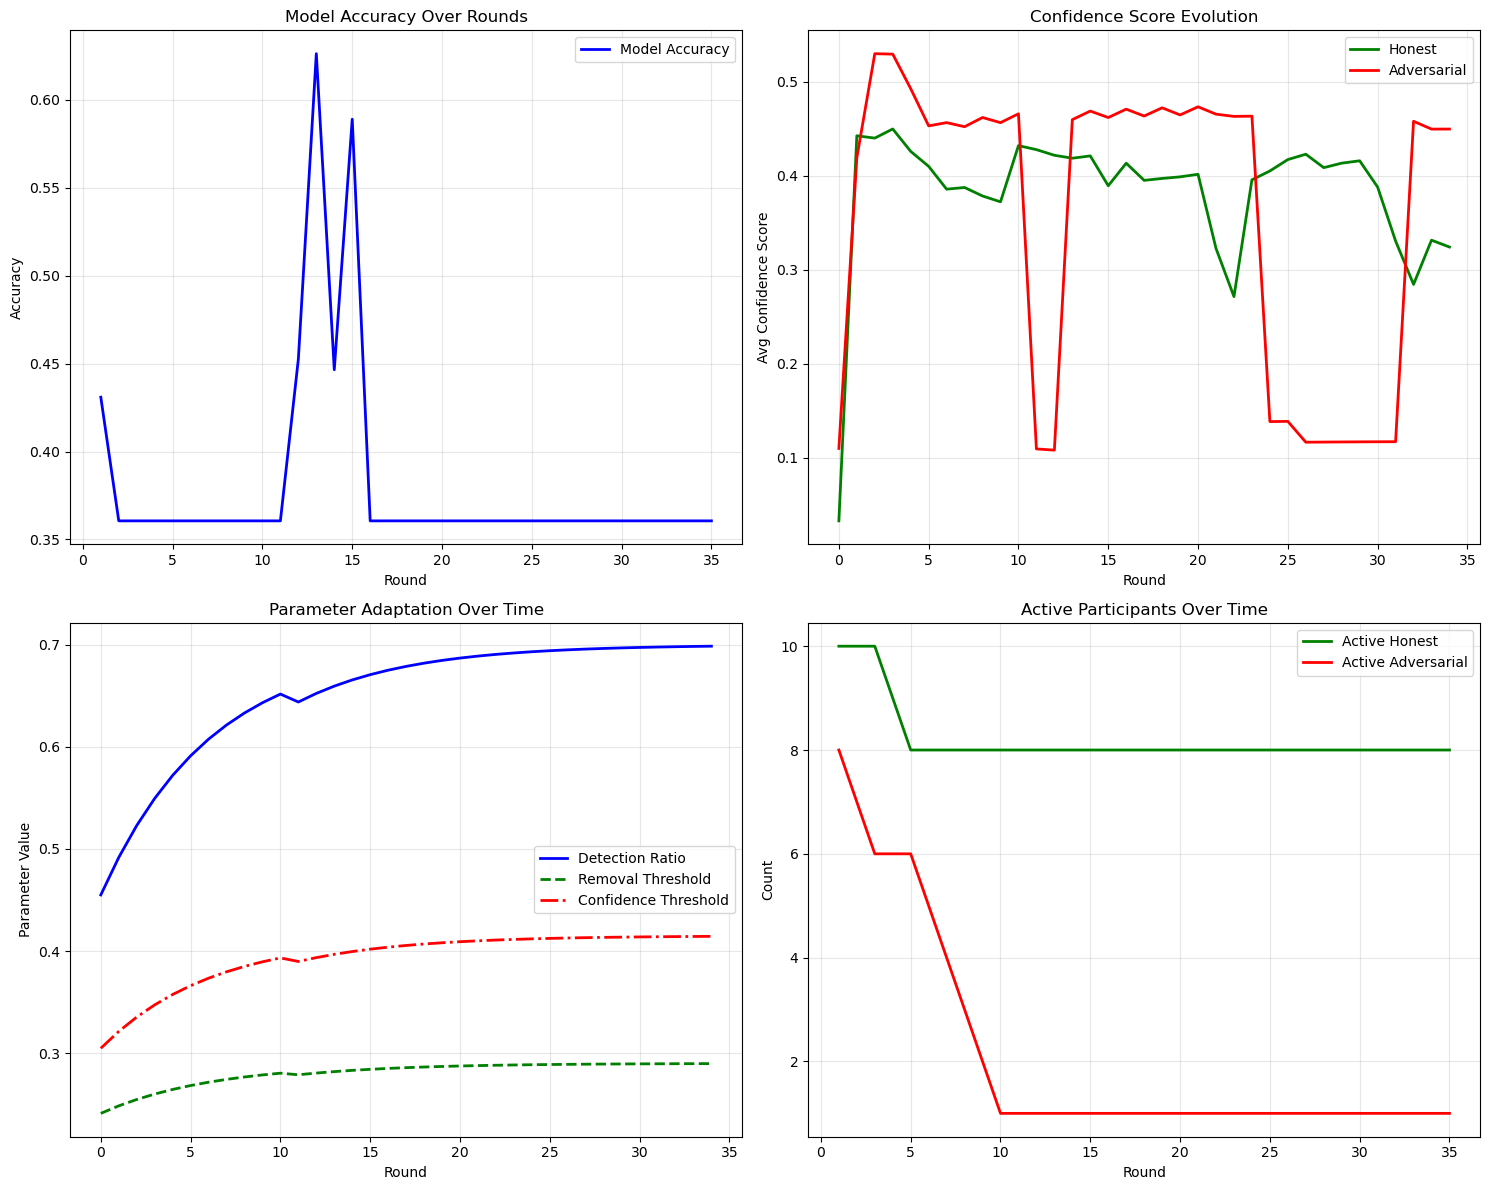

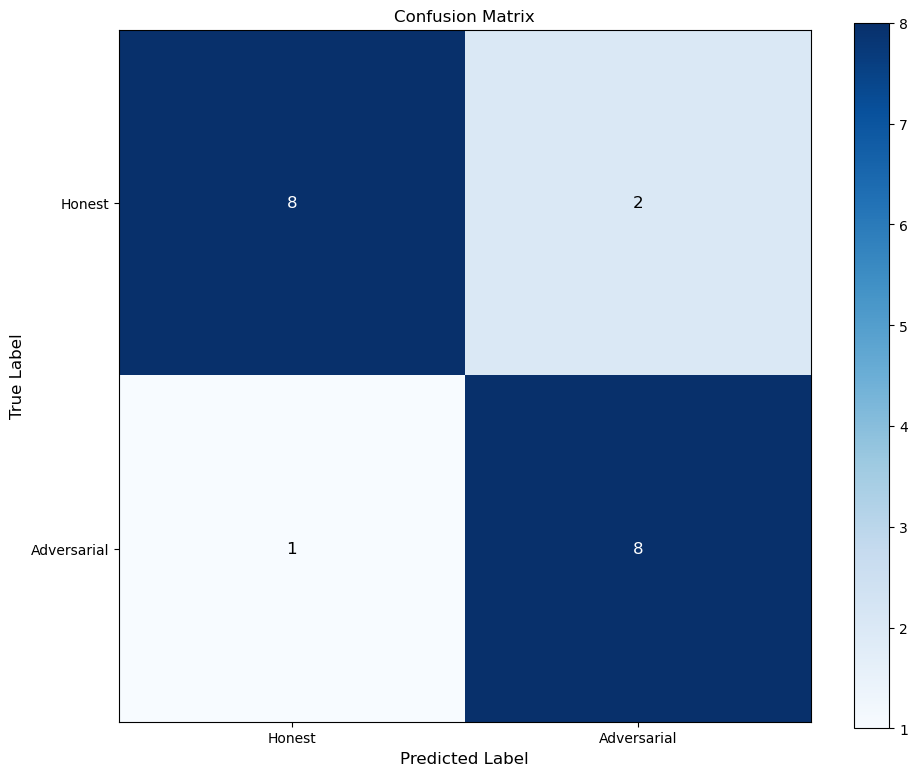


DETECTION PERFORMANCE:
------------------------------------------------------------
Accuracy: 84.21%
Precision: 80.00%
Recall: 88.89%
F1 Score: 84.21%
------------------------------------------------------------
Honest Removed: 20.0% (2/10)
Adversarial Removed: 88.9% (8/9)
Removal Preference: 4.4x
------------------------------------------------------------
True Positives: 8
False Positives: 2
True Negatives: 8
False Negatives: 1
------------------------------------------------------------
Enhanced Parameter Adaptation:
 Final Detection Ratio: 0.70
 Recall Focus Factor: 1.1
 Removal Threshold Change: 0.05
 Confidence Threshold Change: 0.11
------------------------------------------------------------

ENHANCED PARTICIPANT BEHAVIOR ANALYSIS:
------------------------------------------------------------
Average selection rate (honest): 0.935
Average selection rate (adversarial): 0.541
Selection rate gap: 0.394

FINAL ENHANCED RESULTS:
Honest participants: 8/10 remaining (20.0% removed)
Ad

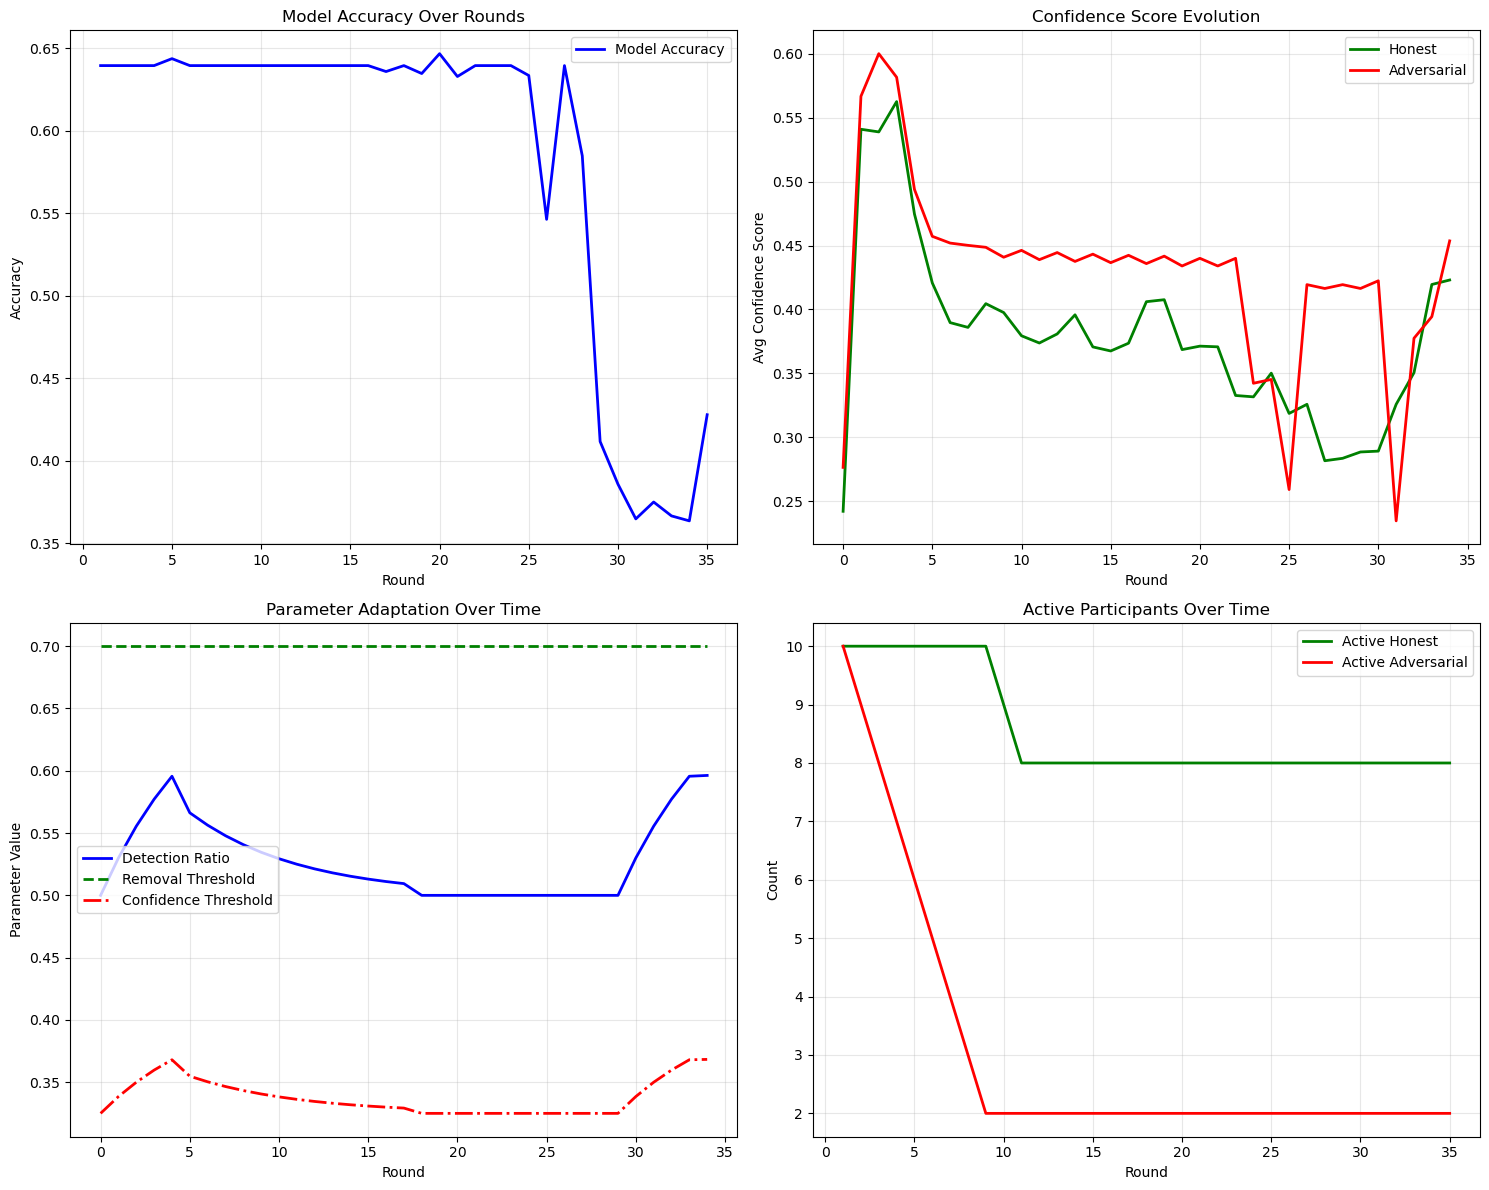

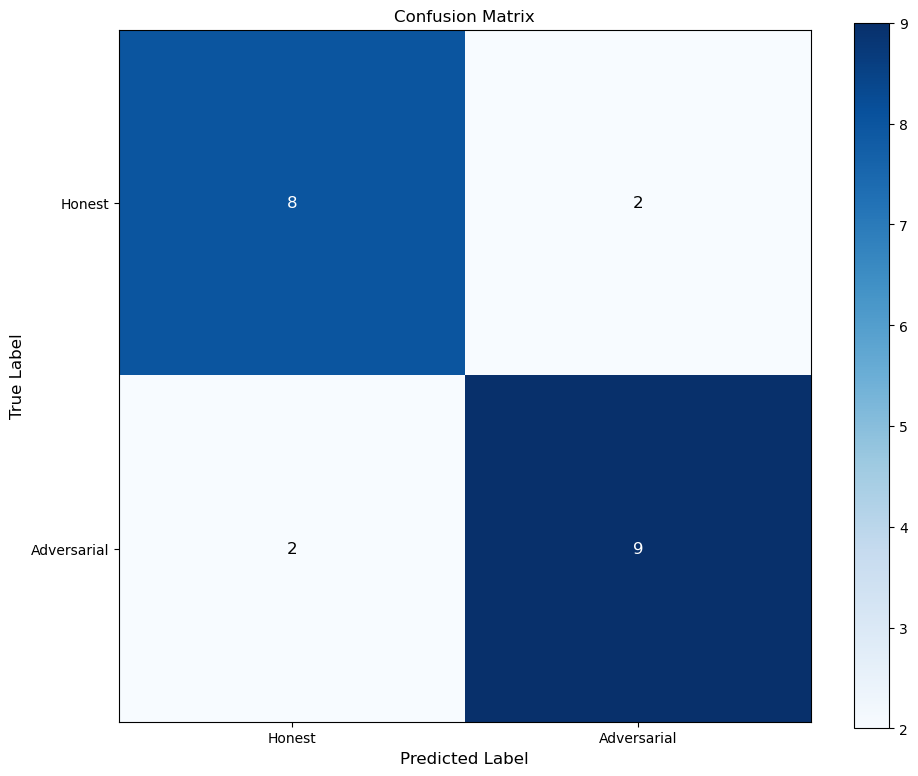


DETECTION PERFORMANCE:
------------------------------------------------------------
Accuracy: 80.95%
Precision: 81.82%
Recall: 81.82%
F1 Score: 81.82%
------------------------------------------------------------
Honest Removed: 20.0% (2/10)
Adversarial Removed: 81.8% (9/11)
Removal Preference: 4.1x
------------------------------------------------------------
True Positives: 9
False Positives: 2
True Negatives: 8
False Negatives: 2
------------------------------------------------------------
Enhanced Parameter Adaptation:
 Final Detection Ratio: 0.60
 Recall Focus Factor: 1.3
 Removal Threshold Change: 0.00
 Confidence Threshold Change: 0.04
------------------------------------------------------------

ENHANCED PARTICIPANT BEHAVIOR ANALYSIS:
------------------------------------------------------------
Average selection rate (honest): 0.837
Average selection rate (adversarial): 0.492
Selection rate gap: 0.345

FINAL ENHANCED RESULTS:
Honest participants: 8/10 remaining (20.0% removed)
A

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from torch.utils.data import Dataset, DataLoader, Subset
from imblearn.over_sampling import SMOTE
import random
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import os
from tsaug import AddNoise, TimeWarp
import warnings
from datetime import datetime, timedelta
import requests
import zipfile

warnings.filterwarnings('ignore')

def set_full_determinism():
    """Set all random seeds for complete reproducibility"""
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = '42'
    
    # Set for DataLoader workers
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    return g, seed_worker

# Set full determinism
data_loader_generator, seed_worker_fn = set_full_determinism()

# Device configuration
device = torch.device('cpu')

# -----------------------------
# Custom Focal Loss
# -----------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.98, gamma=4.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, outputs, targets):
        nll_loss = nn.NLLLoss(reduction='none')(outputs, targets)
        pt = torch.exp(-nll_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * nll_loss
        return focal_loss.mean()

# -----------------------------
# Dataset with deterministic augmentation
# -----------------------------
class V2GDataset(Dataset):
    def __init__(self, csv_path):
        # Set seed for dataset operations
        dataset_rng = random.Random(42)
        np_rng = np.random.RandomState(42)
        
        self.data = pd.read_csv(csv_path)
        print(f"Dataset loaded with {len(self.data)} records")
        print(f"Columns: {', '.join(self.data.columns)}")

        # Timestamp features
        if 'timestamp' in self.data.columns:
            self.data['timestamp'] = pd.to_datetime(self.data['timestamp'])
            self.data['hour'] = self.data['timestamp'].dt.hour
            self.data['day_of_week'] = self.data['timestamp'].dt.dayofweek
            self.data['is_weekend'] = (self.data['day_of_week'] >= 5).astype(int)
        else:
            self.data['hour'] = 0
            self.data['day_of_week'] = 0
            self.data['is_weekend'] = 0

        # Feature engineering
        eps = 1e-6
        self.data['charge_discharge_ratio'] = self.data['current_charge_kWh'] / (self.data['discharge_rate_kW'] + eps)
        self.data['energy_hour_interaction'] = self.data['energy_requested_kWh'] * self.data['hour']
        self.data['charge_capacity_ratio'] = self.data['current_charge_kWh'] / (self.data['battery_capacity_kWh'] + eps)
        self.data['efficiency_estimate'] = self.data['energy_requested_kWh'] / (self.data['discharge_rate_kW'] * 0.25 + eps)

        # Labels
        if 'label' not in self.data.columns:
            raise ValueError("Dataset must contain a 'label' column")
        self.data['label'] = self.data['label'].astype(str).str.lower()
        valid_labels = ['honest', 'adversarial']
        self.data = self.data[self.data['label'].isin(valid_labels)]
        if self.data.empty:
            raise ValueError("No valid labels found in dataset. Expected 'honest' or 'adversarial'.")

        initial_len = len(self.data)
        self.data = self.data.dropna(subset=['label'])
        if len(self.data) < initial_len:
            print(f"Removed {initial_len - len(self.data)} rows with missing labels")

        # Required fields
        if 'participant_id' not in self.data.columns:
            raise ValueError("Dataset must contain a 'participant_id' column")

        # Features
        feature_cols = [
            'battery_capacity_kWh', 'current_charge_kWh', 'discharge_rate_kW',
            'energy_requested_kWh', 'hour', 'charge_discharge_ratio',
            'energy_hour_interaction', 'charge_capacity_ratio',
            'efficiency_estimate', 'day_of_week', 'is_weekend'
        ]
        for col in feature_cols:
            if col not in self.data.columns:
                raise ValueError(f"Missing feature column: {col}")

        self.features = self.data[feature_cols].values
        self.labels = self.data['label'].values
        self.participant_ids = self.data['participant_id'].values
        self.original_indices = np.arange(len(self.data))

        # Pre-SMOTE stats
        self.label_encoder = LabelEncoder()
        original_labels = self.label_encoder.fit_transform(self.labels)
        print(f"Label classes: {', '.join(str(cls) for cls in self.label_encoder.classes_)}")

        unique_participants = len(set(self.participant_ids))
        honest_count = sum(original_labels == self.label_encoder.transform(['honest'])[0])
        adversarial_count = len(original_labels) - honest_count
        print(f"Data distribution: {honest_count} honest, {adversarial_count} adversarial records")

        honest_mask = original_labels == self.label_encoder.transform(['honest'])[0]
        honest_parts = len(set(self.participant_ids[honest_mask]))
        adversarial_parts = unique_participants - honest_parts
        print(f"Participant distribution: {honest_parts} honest, {adversarial_parts} adversarial participants")

        # Deterministic data augmentation without tsaug's random_state
        print("Applying deterministic data augmentation...")
        
        # Add noise manually with fixed seed
        np_rng = np.random.RandomState(42)
        X_aug = self.features.copy()
        noise = np_rng.normal(0, 0.1, size=X_aug.shape)
        X_aug = X_aug + noise
        
        # Time warp simulation - simple shifting with deterministic pattern
        for i in range(X_aug.shape[0]):
            shift_amount = (i % 3) - 1  # Deterministic pattern: -1, 0, 1, -1, 0, 1...
            if shift_amount != 0:
                X_aug[i] = np.roll(X_aug[i], shift_amount)
        
        # Deterministic scaling
        scale_factors = np_rng.uniform(0.9, 1.1, size=(X_aug.shape[0], 1))
        X_aug = X_aug * scale_factors
        
        y_aug = self.labels
        self.features = np.vstack([self.features, X_aug])
        self.labels = np.concatenate([self.labels, y_aug])
        self.participant_ids = np.concatenate([self.participant_ids, self.participant_ids])
        self.original_indices = np.concatenate([self.original_indices, self.original_indices])

        # Global SMOTE with fixed seed
        smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=42)
        self.features, self.labels = smote.fit_resample(self.features, self.labels)
        self.labels = self.label_encoder.transform(self.labels)

        # Ensure minimum 10 records per participant with deterministic sampling
        participant_indices = {}
        for pid in np.unique(self.participant_ids):
            idx = np.where(self.participant_ids == pid)[0]
            participant_indices[pid] = idx
            if len(idx) < 10:
                unique_labels = np.unique(self.labels[idx])
                if len(unique_labels) > 1:
                    extra_samples, extra_labels = smote.fit_resample(self.features[idx], self.labels[idx])
                    extra_samples = extra_samples[:10 - len(idx)]
                    extra_labels = extra_labels[:10 - len(idx)]
                else:
                    num_needed = 10 - len(idx)
                    # Deterministic sampling based on participant ID
                    participant_rng = np.random.RandomState(42 + int(pid))
                    indices_to_duplicate = participant_rng.choice(idx, size=num_needed, replace=True)
                    extra_samples = self.features[indices_to_duplicate]
                    extra_labels = self.labels[indices_to_duplicate]

                self.features = np.vstack([self.features, extra_samples])
                self.labels = np.concatenate([self.labels, extra_labels])
                self.participant_ids = np.concatenate([self.participant_ids, [pid] * len(extra_samples)])
                self.original_indices = np.concatenate([self.original_indices, [self.original_indices[idx[0]]] * len(extra_samples)])

        # Scale
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)

        # Stats
        self.num_features = self.features.shape[1]
        self.num_classes = len(self.label_encoder.classes_)
        print(f"Features: {self.num_features}, Classes: {self.num_classes}")
        print(f"Dataset participant IDs: {sorted(set(self.participant_ids))}")

        # Tensors
        self.features = torch.tensor(self.features, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

        # Group indices by participant
        self.participant_indices = defaultdict(list)
        for idx, pid in enumerate(self.participant_ids):
            self.participant_indices[pid].append(idx)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

    def get_participant_data(self, participant_id):
        indices = self.participant_indices.get(participant_id, [])
        return self.features[indices], self.labels[indices]

    def get_participant_indices(self, participant_id):
        return self.participant_indices.get(participant_id, [])

    def get_participant_type(self, participant_id):
        indices = self.get_participant_indices(participant_id)
        if not indices:
            return None
        labels = self.labels[indices].numpy()
        return 'honest' if np.mean(labels == self.label_encoder.transform(['honest'])[0]) > 0.5 else 'adversarial'

    def get_original_indices(self):
        return self.original_indices

# -----------------------------
# Model
# -----------------------------
class V2GClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=512, num_classes=2, dropout=0.35):
        super(V2GClassifier, self).__init__()
        # Initialize weights with fixed seed
        torch.manual_seed(42)
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.hidden_layer1 = nn.Linear(hidden_size, hidden_size // 2)
        self.norm2 = nn.LayerNorm(hidden_size // 2)
        self.hidden_layer2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.norm3 = nn.LayerNorm(hidden_size // 4)
        self.output_layer = nn.Linear(hidden_size // 4, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
        # Initialize weights deterministically
        self._reset_parameters()
        
    def _reset_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
                    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden_layer1(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden_layer2(x)
        x = self.norm3(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return self.log_softmax(x)

# -----------------------------
# Enhanced Adaptive Parameters
# -----------------------------
class EnhancedAdaptiveParameters:
    def __init__(self, num_honest, num_adversarial, adaptive_mode=True):
        self.num_honest = num_honest
        self.num_adversarial = num_adversarial
        self.adversarial_majority = num_adversarial > num_honest
        self.adaptive_mode = adaptive_mode
        self.current_detected_ratio = 0.5
        self.enhanced_init_parameters()
        self.init_parameters()

    def enhanced_init_parameters(self):
        # Dynamic thresholds based on scenario
        if self.adversarial_majority:
            self.recall_focus_factor = 1.3  # Prioritize catching adversaries
            self.precision_penalty = 0.8    # Accept more false positives
        else:
            self.recall_focus_factor = 1.1
            self.precision_penalty = 0.9
            
        # Enhanced detection windows
        self.short_term_window = 3
        self.long_term_window = 10
        self.consistency_threshold = 0.7
        
        # Multi-modal confidence scoring
        self.gradient_weight = 0.35
        self.behavior_weight = 0.30
        self.temporal_weight = 0.20
        self.reputation_weight = 0.15

    def init_parameters(self):
        self.num_byzantines = 15
        total_participants = self.num_honest + self.num_adversarial
        
        # Krum-specific parameters
        self.krum_f = 5  # Maximum number of Byzantine workers to tolerate
        self.krum_m = 10  # Number of selected workers for Krum
        
        # base thresholds
        self.removal_threshold_base = 0.15 if not self.adversarial_majority else 0.75
        self.max_removal_rate_base = 0.80 if not self.adversarial_majority else 0.45
        self.min_removal_threshold_base = 0.15 if not self.adversarial_majority else 0.70
        self.bootstrap_rounds_base = 1 if not self.adversarial_majority else 3
        self.whitelist_rounds_base = 5 if not self.adversarial_majority else 30
        self.confidence_threshold_base = 0.10
        self.reputation_decay_base = 0.95 if not self.adversarial_majority else 0.90
        self.honest_protection_factor_base = 17.0 if not self.adversarial_majority else 10.0
        self.forced_removal_base = True
        self.min_accuracy_threshold_base = 0.50
        self.adv_per_round_limit_base = 18
        self.patience_base = 8
        self.min_rounds_base = 10
        self.suspicion_weight_base = 0.60
        self.selection_factor_weight_base = 0.25
        self.behavior_factor_weight_base = 0.30
        self.consecutive_factor_weight_base = 0.05
        self.reputation_factor_weight_base = 0.00
        
        # adversarial scenario variants
        self.removal_threshold_adv = 0.35
        self.max_removal_rate_adv = 1.00
        self.min_removal_threshold_adv = 0.30
        self.bootstrap_rounds_adv = 0
        self.whitelist_rounds_adv = 30
        self.confidence_threshold_adv = 0.55
        self.reputation_decay_adv = 0.90
        self.honest_protection_factor_adv = 15.0
        self.forced_removal_adv = True
        self.min_accuracy_threshold_adv = 0.40
        self.adv_per_round_limit_adv = 30
        self.patience_adv = 8
        self.min_rounds_adv = 20
        self.suspicion_weight_adv = 0.35
        self.selection_factor_weight_adv = 0.20
        self.behavior_factor_weight_adv = 0.25
        self.consecutive_factor_weight_adv = 0.00
        self.reputation_factor_weight_adv = 0.20
        self.precision_boost_factor = 1.2  # New parameter
        self.fp_penalty_weight = 0.3  # Penalize false positives more

        self.honest_removal_budget = max(1, int(round(self.num_honest * 0.15)))
        self.safe_list_selection_threshold = 0.4
        self.safe_list_reputation_threshold = 0.65
        self.gradient_cv_threshold = 0.30
        self.behavioral_flag_threshold = 1.8
        self.reputation_penalty = 0.18
        self.min_selection_rate = 0.01
        self.honest_selection_rate_threshold = 0.48
        self.honest_reputation_threshold = 0.88
        self.honest_gradient_cv_threshold = 0.22
        self.honest_accuracy_threshold = 0.58
        self.update_factor = 0.15
        self.max_adaptation = 0.85
        self.safe_reputation_threshold = 0.85
        
        # Krum parameters - adjust based on scenario
        if self.adversarial_majority:
            self.krum_f = min(8, self.num_adversarial - 1)  # More tolerant in adversarial majority
            self.krum_m = max(5, self.num_honest)  # Focus on preserving honest participants
        else:
            self.krum_f = min(5, self.num_adversarial)  # Standard tolerance
            self.krum_m = min(15, total_participants - 2)  # Standard selection
            
        self.update_parameters(self.adversarial_majority)

    def update_parameters(self, adversarial_focus):
        if isinstance(adversarial_focus, bool):
            adv_ratio = 1.0 if adversarial_focus else 0.0
        else:
            adv_ratio = min(max(adversarial_focus, 0.0), 1.0)

        self.removal_threshold = max(self.removal_threshold_base + adv_ratio * (self.removal_threshold_adv - self.removal_threshold_base), self.min_removal_threshold_base)
        self.max_removal_rate = self.max_removal_rate_base + adv_ratio * (self.max_removal_rate_adv - self.max_removal_rate_base)
        self.bootstrap_rounds = int(self.bootstrap_rounds_base + adv_ratio * (self.bootstrap_rounds_adv - self.bootstrap_rounds_base))
        self.whitelist_rounds = int(self.whitelist_rounds_base + adv_ratio * (self.whitelist_rounds_adv - self.whitelist_rounds_base))
        self.confidence_threshold = self.confidence_threshold_base + adv_ratio * (self.confidence_threshold_adv - self.confidence_threshold_base)
        self.reputation_decay = self.reputation_decay_base + adv_ratio * (self.reputation_decay_adv - self.reputation_decay_base)
        self.honest_protection_factor = self.honest_protection_factor_base + adv_ratio * (self.honest_protection_factor_adv - self.honest_protection_factor_base)
        self.forced_removal = True if adv_ratio > 0.3 else self.forced_removal_base
        self.min_accuracy_threshold = self.min_accuracy_threshold_base + adv_ratio * (self.min_accuracy_threshold_adv - self.min_accuracy_threshold_base)
        self.adv_per_round_limit = int(self.adv_per_round_limit_base + adv_ratio * (self.adv_per_round_limit_adv - self.adv_per_round_limit_base))
        self.patience = int(self.patience_base + adv_ratio * (self.patience_adv - self.patience_base))
        self.min_rounds = int(self.min_rounds_base + adv_ratio * (self.min_rounds_adv - self.min_rounds_base))
        self.suspicion_weight = self.suspicion_weight_base + adv_ratio * (self.suspicion_weight_adv - self.suspicion_weight_base)
        self.selection_factor_weight = self.selection_factor_weight_base + adv_ratio * (self.selection_factor_weight_adv - self.selection_factor_weight_base)
        self.behavior_factor_weight = self.behavior_factor_weight_base + adv_ratio * (self.behavior_factor_weight_adv - self.behavior_factor_weight_base)
        self.consecutive_factor_weight = self.consecutive_factor_weight_base + adv_ratio * (self.consecutive_factor_weight_adv - self.consecutive_factor_weight_base)
        self.reputation_factor_weight = self.reputation_factor_weight_base + adv_ratio * (self.reputation_factor_weight_adv - self.reputation_factor_weight_base)
        
        # Adapt Krum parameters based on adversarial ratio
        if adv_ratio > 0.7:
            self.krum_f = min(10, self.num_adversarial)  # Very high tolerance in highly adversarial environments
            self.krum_m = max(3, self.num_honest)  # Very selective
        elif adv_ratio > 0.4:
            self.krum_f = min(7, self.num_adversarial)
            self.krum_m = max(5, self.num_honest)
        else:
            self.krum_f = min(5, self.num_adversarial)
            self.krum_m = min(15, self.num_honest + self.num_adversarial - 2)

    def update_enhanced_parameters(self, performance_metrics):
        """Update based on actual detection performance"""
        current_recall = performance_metrics.get('current_recall', 0.5)
        current_precision = performance_metrics.get('current_precision', 0.5)
        
        # Adjust thresholds based on performance gaps
        recall_gap = 0.8 - current_recall  # Target 80% recall
        precision_gap = 0.7 - current_precision  # Target 70% precision
        
        # More aggressive if recall is low
        if recall_gap > 0.2:
            self.removal_threshold *= 0.8  # Lower threshold to catch more
            self.confidence_threshold *= 0.85
            print(f"AGGRESSIVE MODE: Lowering thresholds (recall gap: {recall_gap:.2f})")
        
        # Balance if precision is too low
        if precision_gap > 0.3:
            self.removal_threshold *= 1.2  # Raise threshold to reduce FPs
            print(f"BALANCING MODE: Raising threshold (precision gap: {precision_gap:.2f})")

    def adapt_to_environment(self, metric_data):
        if not self.adaptive_mode:
            return
        avg_grad_cv = metric_data.get('avg_gradient_cv', 0.5)
        selection_variance = metric_data.get('selection_variance', 0.5)
        recent_accuracy = metric_data.get('recent_accuracy', 0.6)
        confidence_disparity = metric_data.get('confidence_disparity', 0.5)

        environment_assessment = (
            (avg_grad_cv > 0.30) * 0.40 +
            (selection_variance > 0.20) * 0.30 +
            (recent_accuracy < 0.55) * 0.20 +
            (confidence_disparity > 0.20) * 0.10
        )

        self.current_detected_ratio = (1 - self.update_factor) * self.current_detected_ratio + self.update_factor * environment_assessment
        mid_point = 0.5
        if self.adversarial_majority:
            self.current_detected_ratio = max(mid_point, min(1.0, self.current_detected_ratio))
        else:
            self.current_detected_ratio = min(max(0.0, self.current_detected_ratio), mid_point + self.max_adaptation)

        self.update_parameters(self.current_detected_ratio)

    def get_status(self):
        return {
            "detected_ratio": self.current_detected_ratio,
            "removal_threshold": self.removal_threshold,
            "confidence_threshold": self.confidence_threshold,
            "max_removal_rate": self.max_removal_rate,
            "forced_removal": self.forced_removal,
            "behavior_weight": self.behavior_factor_weight,
            "selection_weight": self.selection_factor_weight,
            "krum_f": self.krum_f,
            "krum_m": self.krum_m,
            "recall_focus": self.recall_focus_factor
        }

# -----------------------------
# Enhanced Server with Multi-Stage Detection
# -----------------------------
class EnhancedFederatedServer:
    def __init__(self, model, num_honest, num_adversarial, device='cpu', dataset=None, adaptive_mode=True):
        self.model = model.to(device)
        self.device = device
        self.num_honest = num_honest
        self.num_adversarial = num_adversarial
        self.dataset = dataset
        self.current_round = 0
        self.best_accuracy = 0.0
        self.rounds_without_improvement = 0
        self.participants = {}
        self.reputation_scores = {}
        self.confidence_scores = {}
        self.gradient_norms = defaultdict(list)
        self.gradient_directions = defaultdict(list)
        self.selection_history = defaultdict(list)
        self.accuracy_history = []
        self.removed_participants = []
        self.safe_list = set()
        self.honest_removed_count = 0
        self.selection_rates = defaultdict(float)
        self.gradient_cvs = defaultdict(float)
        self.confidence_history = defaultdict(list)
        self.suspicious_patterns = defaultdict(int)
        self.accuracy_improvements = []
        self.parameter_history = []
        self.gradient_cosine_similarities = defaultdict(list)
        self.gradient_deviations = defaultdict(float)
        self.participation_consistency = defaultdict(float)
        self.historical_suspicion = defaultdict(list)
        self.last_selected_round = defaultdict(int)
        self.detection_performance_history = []
        self.params = EnhancedAdaptiveParameters(num_honest, num_adversarial, adaptive_mode)

        print(f"{'ADVERSARIAL MAJORITY DETECTED' if self.params.adversarial_majority else 'HONEST MAJORITY DETECTED'} - Using {'adaptive' if adaptive_mode else 'fixed'} strategy")
        print(f"Detection params: threshold={self.params.removal_threshold:.2f}, rate={self.params.max_removal_rate:.2f}")
        print(f"Krum params: f={self.params.krum_f}, m={self.params.krum_m}")
        print(f"Recall focus factor: {self.params.recall_focus_factor:.1f}")
        print(f"Honest protection: budget={self.params.honest_removal_budget}, factor={self.params.honest_protection_factor:.2f}")

        self._initialize_participants(dataset)

    def _initialize_participants(self, dataset):
        available_pids = list(set(dataset.participant_ids))
        if len(available_pids) < self.num_honest + self.num_adversarial:
            print(f"Warning: Only {len(available_pids)} participants available, adjusting counts")
            total = self.num_honest + self.num_adversarial
            self.num_honest = int(len(available_pids) * (self.num_honest / total))
            self.num_adversarial = len(available_pids) - self.num_honest
            print(f"Adjusted to {self.num_honest} honest and {self.num_adversarial} adversarial participants")

        # Deterministic shuffling
        rng = random.Random(42)
        available_pids_sorted = sorted(available_pids)
        rng.shuffle(available_pids_sorted)
        honest_ids = available_pids_sorted[:self.num_honest]
        adversarial_ids = available_pids_sorted[self.num_honest:self.num_honest + self.num_adversarial]

        def _new_participant(pid):
            # Set seed for model initialization based on participant ID
            torch.manual_seed(42 + pid)
            model = V2GClassifier(self.model.input_layer.in_features, num_classes=self.model.output_layer.out_features).to(self.device)
            
            return {
                'model': model,
                'type': None,
                'data': None,
                'active': True,
                'suspicion_score': 0.0,
                'behavioral_flags': 0.0,
                'selection_count': 0,
                'gradient_history': deque(maxlen=5),
                'accuracy_history': deque(maxlen=10),
                'detected_anomalies': 0,
                'participation_rate': 1.0,
                'consistent_behavior_score': 1.0,
                'rounds_since_selection': 0,
                'temporal_behavior': deque(maxlen=10)
            }

        for idx in honest_ids:
            p = _new_participant(idx)
            p['type'] = 'honest'
            self.participants[idx] = p
            self.reputation_scores[idx] = 1.0
            self.confidence_scores[idx] = 0.0

        for idx in adversarial_ids:
            p = _new_participant(idx)
            p['type'] = 'adversarial'
            self.participants[idx] = p
            self.reputation_scores[idx] = 1.0
            self.confidence_scores[idx] = 0.0

        print(f"Server initialized with {self.num_honest} honest and {self.num_adversarial} adversarial participants")

    def deterministic_selection(self, active_ids, k, reputations, round_idx):
        """Deterministic participant selection based on round index"""
        rng = np.random.RandomState(42 + round_idx)
        probs = np.array([reputations.get(idx, 1.0) for idx in active_ids], dtype=float)
        probs = probs + 1e-6
        probs = probs / probs.sum()
        return list(rng.choice(active_ids, size=min(k, len(active_ids)), replace=False, p=probs))

    # -------- Enhanced Gradient Metrics --------
    def calculate_advanced_gradient_metrics(self, idx, gradients):
        """Enhanced gradient analysis with multiple detection signals"""
        grad_vector = torch.cat([g.flatten() for g in gradients]).to(self.device)
        norm = torch.norm(grad_vector).item()
        
        # 1. Multi-scale norm analysis
        self.gradient_norms[idx].append(norm)
        if len(self.gradient_norms[idx]) >= 3:
            norm_trend = np.polyfit(range(3), self.gradient_norms[idx][-3:], 1)[0]
            if abs(norm_trend) > 0.5:  # Rapid changes
                self.participants[idx]['behavioral_flags'] += 3.0
        
        # 2. Gradient distribution analysis
        grad_std = torch.std(grad_vector).item()
        grad_mean = torch.mean(grad_vector).item()
        if abs(grad_std / (grad_mean + 1e-10)) > 2.0:  # High variance
            self.participants[idx]['behavioral_flags'] += 2.0
        
        # 3. Layer-wise gradient analysis
        layer_grads = [torch.norm(g).item() for g in gradients]
        layer_ratios = []
        for i in range(1, len(layer_grads)):
            if layer_grads[i-1] > 0:
                ratio = layer_grads[i] / layer_grads[i-1]
                layer_ratios.append(ratio)
        
        if layer_ratios:
            unusual_ratios = sum(1 for r in layer_ratios if r > 10 or r < 0.1)
            if unusual_ratios / len(layer_ratios) > 0.3:
                self.participants[idx]['behavioral_flags'] += 4.0

        # CV (existing functionality)
        norms = self.gradient_norms[idx][-5:] if len(self.gradient_norms[idx]) >= 5 else self.gradient_norms[idx]
        if len(norms) >= 2:
            variance = np.var(norms)
            mean_norm = np.mean(norms)
            cv = np.sqrt(variance) / (mean_norm + 1e-10)
            self.gradient_cvs[idx] = cv
            if cv > self.params.gradient_cv_threshold:
                self.participants[idx]['behavioral_flags'] += 4.0
                self.suspicious_patterns[idx] += 2.0
            elif cv > self.params.gradient_cv_threshold * 0.7:
                self.participants[idx]['behavioral_flags'] += 0.8
                self.suspicious_patterns[idx] += 0.8

        # Direction change (existing functionality)
        if len(self.gradient_directions[idx]) >= 1:
            prev_grad = torch.cat([g.flatten() for g in self.gradient_directions[idx][-1]]).to(self.device)
            direction_change = torch.dot(grad_vector / (norm + 1e-10), prev_grad / (torch.norm(prev_grad) + 1e-10)).item()
            self.gradient_cosine_similarities[idx].append(direction_change)

        self.participants[idx]['rounds_since_selection'] += 1
        self.gradient_directions[idx].append([g.clone().detach() for g in gradients])

    # -------- Enhanced Krum with Recall Focus --------
    def recall_focused_krum(self, gradients_dict, selected_ids=None):
        """Krum variant that prioritizes recall"""
        
        # First, run standard Krum
        krum_grads, krum_selected = self.aggregate_with_krum(gradients_dict, selected_ids)
        
        # Additional recall-focused analysis
        if len(gradients_dict) >= 5:
            high_suspicion_grads = self._get_high_suspicion_gradients(gradients_dict)
            
            if high_suspicion_grads:
                # Compare Krum selection with high-suspicion gradients
                krum_participant = krum_selected[0] if krum_selected else None
                if krum_participant in high_suspicion_grads:
                    # Krum selected a suspicious participant - consider alternatives
                    alternative = self._find_best_alternative(gradients_dict, high_suspicion_grads)
                    if alternative:
                        print(f"KRUM OVERRIDE: Selected alternative {alternative} instead of suspicious {krum_participant}")
                        return [g.clone().detach() for g in gradients_dict[alternative]], [alternative]
        
        return krum_grads, krum_selected

    def _get_high_suspicion_gradients(self, gradients_dict):
        """Identify gradients from highly suspicious participants"""
        high_suspicion = []
        suspicion_threshold = self.params.confidence_threshold * 1.5
        
        for idx in gradients_dict:
            if (self.confidence_scores.get(idx, 0) > suspicion_threshold and 
                self.participants[idx]['behavioral_flags'] > 2.0):
                high_suspicion.append(idx)
        
        return high_suspicion

    def _find_best_alternative(self, gradients_dict, excluded_ids):
        """Find the best alternative to excluded suspicious participants"""
        candidates = [idx for idx in gradients_dict if idx not in excluded_ids]
        
        if not candidates:
            return None
        
        # Use reputation-based selection
        best_candidate = max(candidates, 
                            key=lambda x: self.reputation_scores.get(x, 0) * 
                                        (1 - self.confidence_scores.get(x, 0)))
        return best_candidate

    def aggregate_with_krum(self, gradients_dict, selected_ids=None):
        """Krum aggregation: selects the most representative gradient vector"""
        if not gradients_dict:
            return None, []

        active_ids = [idx for idx, p in self.participants.items() if p['active'] and idx in gradients_dict]
        if not active_ids:
            return None, []

        # Use deterministic selection if not provided
        if selected_ids is None:
            reputations = {idx: self.reputation_scores.get(idx, 1.0) for idx in active_ids}
            selected_ids = self.deterministic_selection(active_ids, self.params.krum_m, reputations, self.current_round)

        # Mark selection history and rates
        for idx in active_ids:
            was_selected = idx in selected_ids
            self.selection_history[idx].append(was_selected)
            if was_selected:
                self.participants[idx]['selection_count'] += 1
                self.participants[idx]['rounds_since_selection'] = 0
                self.last_selected_round[idx] = self.current_round
            else:
                self.participants[idx]['rounds_since_selection'] += 1
            self.selection_rates[idx] = self.participants[idx]['selection_count'] / max(1, self.current_round)

        # Convert gradients to flat vectors for distance computation
        gradient_vectors = {}
        for idx in selected_ids:
            if idx in gradients_dict:
                grad_vec = torch.cat([g.flatten() for g in gradients_dict[idx]]).to(self.device)
                gradient_vectors[idx] = grad_vec

        n = len(selected_ids)
        f = self.params.krum_f
        
        if n <= 2 * f + 1:
            # Not enough participants for Krum to be effective, fall back to average
            print(f"Warning: Not enough participants for Krum (n={n}, f={f}), using average")
            aggregated = self._average_gradients(gradients_dict, selected_ids)
            return aggregated, selected_ids

        # Compute pairwise distances
        distances = {}
        for i in selected_ids:
            distances[i] = {}
            for j in selected_ids:
                if i != j:
                    dist = torch.norm(gradient_vectors[i] - gradient_vectors[j]).item()
                    distances[i][j] = dist

        # Compute scores for each participant (sum of closest n-f-2 distances)
        scores = {}
        for i in selected_ids:
            # Get distances from i to all others and sort
            dist_list = sorted([distances[i][j] for j in selected_ids if j != i])
            # Sum the smallest n-f-2 distances
            score = sum(dist_list[:n - f - 2])
            scores[i] = score

        # Select participant with minimum score
        best_participant = min(scores, key=scores.get)
        
        print(f"Krum selected participant {best_participant} with score {scores[best_participant]:.4f}")

        # Return the gradients of the best participant
        aggregated = [g.clone().detach() for g in gradients_dict[best_participant]]
        
        return aggregated, selected_ids

    def _average_gradients(self, gradients_dict, selected_ids):
        """Fallback averaging when Krum cannot be applied"""
        if not selected_ids:
            return None
            
        # Simple averaging of gradients
        aggregated = []
        num_params = len(next(iter(gradients_dict.values())))
        
        for i in range(num_params):
            grad_sum = None
            count = 0
            for idx in selected_ids:
                if idx in gradients_dict:
                    grad = gradients_dict[idx][i]
                    if grad_sum is None:
                        grad_sum = torch.zeros_like(grad)
                    grad_sum += grad
                    count += 1
            if count > 0:
                aggregated.append(grad_sum / count)
            else:
                aggregated.append(torch.zeros_like(next(iter(gradients_dict.values()))[i]))
                
        return aggregated

    # -------- Multi-Stage Detection Pipeline --------
    def enhanced_anomaly_detection(self, honest_candidates, val_loader=None):
        """Multi-stage detection with improved recall"""
        
        stage1_candidates = self._behavior_based_detection(honest_candidates)
        stage2_candidates = self._temporal_analysis_detection(stage1_candidates)
        stage3_candidates = self._collaborative_detection(stage2_candidates)
        
        
        return self._final_ranking(stage3_candidates)

    def _behavior_based_detection(self, honest_candidates):
        """Stage 1: Behavioral pattern analysis"""
        candidates = []
        
        for idx in self.participants:
            if not self.participants[idx]['active'] or idx in honest_candidates:
                continue
                
            behavior_score = 0.0
            
            # 1. Gradient consistency
            if len(self.gradient_cosine_similarities[idx]) >= 3:
                recent_similarities = self.gradient_cosine_similarities[idx][-3:]
                consistency = np.mean(recent_similarities)
                if consistency < 0.3 or consistency > 0.95:
                    behavior_score += (1.0 - min(consistency, 1.0 - consistency)) * 2.0
            
            # 2. Selection pattern analysis
            if len(self.selection_history[idx]) >= 5:
                selection_pattern = self.selection_history[idx][-5:]
                alternating_pattern = sum(selection_pattern[i] != selection_pattern[i-1] 
                                        for i in range(1, len(selection_pattern)))
                if alternating_pattern >= 4:  # Highly alternating pattern
                    behavior_score += 1.5
            
            # 3. Performance inconsistency
            if len(self.participants[idx]['accuracy_history']) >= 3:
                acc_history = self.participants[idx]['accuracy_history']
                acc_std = np.std(list(acc_history))
                if acc_std > 0.3:  # Highly variable performance
                    behavior_score += 1.2
            
            if behavior_score > 1.0:
                candidates.append((idx, behavior_score))
        
        return candidates

    def _temporal_analysis_detection(self, stage1_candidates):
        """Stage 2: Temporal pattern analysis"""
        candidates_dict = {idx: score for idx, score in stage1_candidates}
        
        for idx in self.participants:
            if not self.participants[idx]['active'] or idx in candidates_dict:
                continue
                
            temporal_score = 0.0
            
            # 1. Round-based behavior changes
            if self.current_round > 10:
                early_rounds = min(5, self.current_round // 2)
                recent_confidence = np.mean(self.confidence_history[idx][-5:]) if len(self.confidence_history[idx]) >= 5 else 0
                early_confidence = np.mean(self.confidence_history[idx][:early_rounds]) if len(self.confidence_history[idx]) >= early_rounds else 0
                
                if recent_confidence > early_confidence * 1.5:  # Deteriorating behavior
                    temporal_score += 1.0
            
            # 2. Reaction to detection pressure
            if self.params.current_detected_ratio > 0.6:
                # Check if behavior changes when detection is high
                recent_flags = self.participants[idx]['behavioral_flags']
                if recent_flags < 1.0:  # Suddenly becomes well-behaved under pressure
                    temporal_score += 0.8
            
            if temporal_score > 0.7:
                candidates_dict[idx] = candidates_dict.get(idx, 0) + temporal_score
        
        return [(idx, score) for idx, score in candidates_dict.items()]

    def _collaborative_detection(self, stage2_candidates):
        """Stage 3: Cross-participant correlation analysis"""
        candidates_dict = {idx: score for idx, score in stage2_candidates}
        
        # Find participants with correlated suspicious behavior
        suspicious_pairs = []
        for i in self.participants:
            if not self.participants[i]['active'] or i in candidates_dict:
                continue
            for j in self.participants:
                if i >= j or not self.participants[j]['active'] or j not in candidates_dict:
                    continue
                
                # Check for correlated gradient patterns
                if (i in self.gradient_cosine_similarities and j in self.gradient_cosine_similarities and
                    len(self.gradient_cosine_similarities[i]) >= 3 and len(self.gradient_cosine_similarities[j]) >= 3):
                    
                    i_similarities = self.gradient_cosine_similarities[i][-3:]
                    j_similarities = self.gradient_cosine_similarities[j][-3:]
                    
                    correlation = np.corrcoef(i_similarities, j_similarities)[0,1]
                    if abs(correlation) > 0.8:  # Highly correlated behavior
                        suspicious_pairs.append((i, j))
        
        # Boost scores for correlated participants
        for i, j in suspicious_pairs:
            if i not in candidates_dict:
                candidates_dict[i] = 0.5  # Initial score for correlation
            candidates_dict[i] += 0.3
        
        return [(idx, score) for idx, score in candidates_dict.items()]

    def _final_ranking(self, candidates):
        """Final ranking and selection of participants to remove"""
        if not candidates:
            return [], 0
        
        # Apply recall-focused adjustments
        enhanced_candidates = []
        for idx, score in candidates:
            # Boost scores for participants with high behavioral flags
            enhanced_score = score * self.params.recall_focus_factor
            
            # Additional boost for consistent suspicious patterns
            if (idx in self.historical_suspicion and 
                len(self.historical_suspicion[idx]) >= 3):
                suspicion_trend = np.mean(self.historical_suspicion[idx][-3:])
                enhanced_score += suspicion_trend * 0.5
            
            enhanced_candidates.append((idx, enhanced_score))
        
        # Sort by enhanced scores
        enhanced_candidates.sort(key=lambda x: x[1], reverse=True)
        
        # Determine number to remove
        active_count = sum(1 for p in self.participants.values() if p['active'])
        max_removals = min(
            int(active_count * self.params.max_removal_rate),
            self.params.adv_per_round_limit,
            len(enhanced_candidates)
        )
        
        to_remove = [idx for idx, _ in enhanced_candidates[:max_removals]]
        honest_removed = sum(1 for idx in to_remove if self.participants[idx]['type'] == 'honest')
        
        # Apply honest protection
        if self.honest_removed_count + honest_removed > self.params.honest_removal_budget:
            # Remove honest participants from removal list
            to_remove = [idx for idx in to_remove if self.participants[idx]['type'] != 'honest']
            honest_removed = 0
        
        return to_remove, honest_removed

    # -------- Enhanced Early Stopping --------
    def enhanced_early_stopping(self):
        """Early stopping that considers detection performance"""
        if len(self.accuracy_history) < self.params.patience:
            return False
        
        # Calculate current detection performance
        recent_removals = self.removed_participants[-10:] if len(self.removed_participants) >= 10 else self.removed_participants
        if recent_removals:
            true_positives = sum(1 for idx in recent_removals if self.participants[idx]['type'] == 'adversarial')
            false_positives = len(recent_removals) - true_positives
            
            current_recall = true_positives / max(1, sum(1 for p in self.participants.values() 
                                                       if p['type'] == 'adversarial' and not p['active']))
            current_precision = true_positives / max(1, len(recent_removals))
        else:
            current_recall, current_precision = 0, 0
        
        # Update parameters based on performance
        self.params.update_enhanced_parameters({
            'current_recall': current_recall,
            'current_precision': current_precision
        })
        
        # Stop if both model performance and detection performance plateau
        accuracy_plateau = max(self.accuracy_history[-self.params.patience:]) - min(self.accuracy_history[-self.params.patience:]) < 0.01
        detection_plateau = current_recall < 0.3 and current_precision < 0.4  # Poor detection performance
        
        return accuracy_plateau and detection_plateau

    # -------- Existing methods (updated to use enhanced versions) --------
    def update_reputation_scores(self, selected_ids):
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            if idx in selected_ids:
                self.reputation_scores[idx] = min(1.0, self.reputation_scores[idx] + 0.07)
            else:
                self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] * self.params.reputation_decay)

            if self.participants[idx]['behavioral_flags'] >= self.params.behavioral_flag_threshold:
                penalty = self.params.reputation_penalty * (self.participants[idx]['behavioral_flags'] / self.params.behavioral_flag_threshold)
                self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] - penalty)
                self.participants[idx]['behavioral_flags'] = 0

            if self.current_round >= 10 and self.selection_rates[idx] < self.params.min_selection_rate:
                low_selection_penalty = 0.09 * (1.0 + (self.params.min_selection_rate - self.selection_rates[idx]) * 3)
                self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] - low_selection_penalty)

            if len(self.selection_history[idx]) >= 5:
                recent = self.selection_history[idx][-5:]
                if all(recent):
                    self.reputation_scores[idx] = min(1.0, self.reputation_scores[idx] + 0.06)
                elif not any(recent):
                    self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] - 0.08)

            if self.suspicious_patterns[idx] >= 4:
                penalty = 0.08 * (self.suspicious_patterns[idx] / 4)
                self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] - penalty)
                self.suspicious_patterns[idx] = 0

        self._update_safe_list()

    def _update_safe_list(self):
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            if (self.selection_rates[idx] >= self.params.safe_list_selection_threshold and
                self.reputation_scores[idx] >= self.params.safe_list_reputation_threshold and
                self.current_round >= self.params.whitelist_rounds and
                self.gradient_cvs.get(idx, 1.0) < self.params.honest_gradient_cv_threshold):
                self.safe_list.add(idx)
            if idx in self.safe_list and (
                self.reputation_scores[idx] < 0.5 or
                (self.current_round > 15 and self.selection_rates[idx] < 0.3) or
                self.gradient_cvs.get(idx, 0) > self.params.gradient_cv_threshold * 1.5):
                self.safe_list.remove(idx)

    def update_confidence_scores(self):
        active_ids = [idx for idx in self.participants if self.participants[idx]['active']]
        if not active_ids:
            return
        avg_gradient_cv = np.mean([self.gradient_cvs.get(idx, 0) for idx in active_ids]) if active_ids else 0
        selection_rates = [self.selection_rates.get(idx, 0) for idx in active_ids]
        selection_variance = np.var(selection_rates) if len(selection_rates) > 1 else 0
        recent_accuracy = np.mean(self.accuracy_history[-5:]) if len(self.accuracy_history) >= 5 else 0.5
        confidence_values = [self.confidence_scores.get(idx, 0) for idx in active_ids]
        confidence_disparity = np.std(confidence_values) / (np.mean(confidence_values) + 1e-10) if len(active_ids) > 1 else 0

        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            suspicion = min(self.participants[idx]['suspicion_score'] / self.params.removal_threshold, 1.0)
            selection_rate = self.selection_rates.get(idx, 0)
            selection_factor = max(0.0, 1.0 - selection_rate / 0.4)
            behavior_factor = min(self.participants[idx]['behavioral_flags'] / 4.0, 1.0)
            consecutive_factor = 0.0
            if len(self.selection_history[idx]) >= 4:
                recent = self.selection_history[idx][-4:]
                if all(not x for x in recent):
                    consecutive_factor = 1.0
                elif sum(not x for x in recent) >= 3:
                    consecutive_factor = 0.8
            reputation_factor = max(0.0, 1.0 - self.reputation_scores[idx])
            gradient_cv_factor = min(self.gradient_cvs.get(idx, 0) / self.params.gradient_cv_threshold, 1.0)
            gradient_deviation_factor = min(self.gradient_deviations.get(idx, 0) * 1.5, 1.0)
            rounds_since_selection_factor = min(self.participants[idx]['rounds_since_selection'] / 5.0, 1.0)

            weighted_confidence = (
                suspicion * self.params.suspicion_weight * 1.25 +
                selection_factor * self.params.selection_factor_weight +
                behavior_factor * self.params.behavior_factor_weight * 1.2 +
                consecutive_factor * self.params.consecutive_factor_weight +
                reputation_factor * self.params.reputation_factor_weight +
                gradient_cv_factor * 0.35 +
                gradient_deviation_factor * 0.30 +
                rounds_since_selection_factor * 0.20
            )

            self.confidence_scores[idx] = min(1.0, weighted_confidence)
            self.confidence_history[idx].append(self.confidence_scores[idx])
            self.historical_suspicion[idx].append(suspicion)

        self.params.adapt_to_environment({
            'avg_gradient_cv': avg_gradient_cv,
            'selection_variance': selection_variance,
            'recent_accuracy': recent_accuracy,
            'confidence_disparity': confidence_disparity
        })
        self.parameter_history.append(self.params.get_status())
        
    def _last_n_as_list(self, q, n):
        ln = len(q)
        if ln <= n:
            return list(q)
        return [q[i] for i in range(ln - n, ln)]
        
    def identify_honest_participants(self, val_loader=None):
        honest_candidates = []
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            if self.selection_rates[idx] > self.params.honest_selection_rate_threshold:
                honest_candidates.append(idx); continue
            if self.reputation_scores[idx] > self.params.honest_reputation_threshold:
                honest_candidates.append(idx); continue
            if idx in self.gradient_cvs and self.gradient_cvs[idx] < self.params.honest_gradient_cv_threshold:
                honest_candidates.append(idx); continue
            if val_loader and len(self.participants[idx]['accuracy_history']) >= 3:
                ah = self.participants[idx]['accuracy_history']
                last3 = self._last_n_as_list(ah, 3)
                avg_accuracy = np.mean(last3) if last3 else 0.0

                if avg_accuracy > self.params.honest_accuracy_threshold:
                    honest_candidates.append(idx); continue
            if idx in self.safe_list:
                honest_candidates.append(idx); continue
            if idx in self.gradient_cosine_similarities and len(self.gradient_cosine_similarities[idx]) >= 3:
                similarities = self.gradient_cosine_similarities[idx][-3:]
                avg_similarity = np.mean(similarities)
                if avg_similarity > 0.2 and avg_similarity < 0.95:
                    honest_candidates.append(idx); continue
        return honest_candidates

    def evaluate_model(self, val_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total if total > 0 else 0.0

    def evaluate_participant_models(self, val_loader):
        if not val_loader:
            return
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            model = self.participants[idx]['model']
            model.eval()
            correct = 0; total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            accuracy = correct / total if total > 0 else 0.0
            self.participants[idx]['accuracy_history'].append(accuracy)

    def update_model(self, gradients_dict, val_loader=None):
        aggregated_grads, selected_ids = self.recall_focused_krum(gradients_dict)
        if not selected_ids or aggregated_grads is None:
            return 0.0

        # Update reputation and confidence
        self.update_reputation_scores(selected_ids)
        self.update_confidence_scores()

        # Apply aggregated gradients
        for param in self.model.parameters():
            param.grad = None
        for param, grad in zip(self.model.parameters(), aggregated_grads):
            param.grad = grad.clone().detach()

        optimizer = optim.Adam(self.model.parameters(), lr=0.005)
        optimizer.step()

        accuracy = 0.0
        if val_loader:
            accuracy = self.evaluate_model(val_loader)
            self.accuracy_history.append(accuracy)
            if len(self.accuracy_history) >= 2:
                improvement = self.accuracy_history[-1] - self.accuracy_history[-2]
                self.accuracy_improvements.append(improvement)
            self.evaluate_participant_models(val_loader)

        return accuracy

    def check_early_stopping(self):
        return self.enhanced_early_stopping()

    def get_metrics(self):
        active_honest = sum(1 for idx, p in self.participants.items() if p['active'] and p['type'] == 'honest')
        active_adversarial = sum(1 for idx, p in self.participants.items() if p['active'] and p['type'] == 'adversarial')
        honest_selection_rates = [self.selection_rates.get(idx, 0)
                                 for idx, p in self.participants.items()
                                 if p['type'] == 'honest' and p['active']]
        adversarial_selection_rates = [self.selection_rates.get(idx, 0)
                                      for idx, p in self.participants.items()
                                      if p['type'] == 'adversarial' and p['active']]
        avg_honest_selection = np.mean(honest_selection_rates) if honest_selection_rates else 0
        avg_adversarial_selection = np.mean(adversarial_selection_rates) if adversarial_selection_rates else 0
        honest_confidence = [self.confidence_scores.get(idx, 0)
                            for idx, p in self.participants.items()
                            if p['type'] == 'honest' and p['active']]
        adversarial_confidence = [self.confidence_scores.get(idx, 0)
                                 for idx, p in self.participants.items()
                                 if p['type'] == 'adversarial' and p['active']]
        avg_honest_confidence = np.mean(honest_confidence) if honest_confidence else 0
        avg_adversarial_confidence = np.mean(adversarial_confidence) if adversarial_confidence else 0
        
        # Calculate current detection performance
        recent_removals = self.removed_participants[-10:] if len(self.removed_participants) >= 10 else self.removed_participants
        if recent_removals:
            true_positives = sum(1 for idx in recent_removals if self.participants[idx]['type'] == 'adversarial')
            false_positives = len(recent_removals) - true_positives
            current_recall = true_positives / max(1, sum(1 for p in self.participants.values() 
                                                       if p['type'] == 'adversarial' and not p['active']))
            current_precision = true_positives / max(1, len(recent_removals))
        else:
            current_recall, current_precision = 0, 0
            
        return {
            'active_honest': active_honest,
            'active_adversarial': active_adversarial,
            'total_active': active_honest + active_adversarial,
            'avg_honest_selection': avg_honest_selection,
            'avg_adversarial_selection': avg_adversarial_selection,
            'selection_gap': avg_honest_selection - avg_adversarial_selection,
            'avg_honest_confidence': avg_honest_confidence,
            'avg_adversarial_confidence': avg_adversarial_confidence,
            'confidence_gap': avg_adversarial_confidence - avg_honest_confidence,
            'accuracy': self.accuracy_history[-1] if self.accuracy_history else 0,
            'current_params': self.params.get_status(),
            'honest_removed': self.honest_removed_count,
            'safe_list_size': len(self.safe_list),
            'current_recall': current_recall,
            'current_precision': current_precision
        }

# -----------------------------
# Participant training (unchanged)
# -----------------------------
def train_improved_participant(participant, dataset, device, current_round, val_loader=None, server=None):
    model = participant['model']
    model.train()
    lr = 0.001 * (0.9 ** max(0, current_round - 10))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = FocalLoss(alpha=0.98, gamma=4.0)

    data_loader = participant['data']
    if not data_loader:
        return [], 0.0, 0.0

    total_loss = 0.0
    
    # Deterministic adversarial behavior based on participant ID and round
    participant_id = [idx for idx, p in server.participants.items() if p == participant][0] if server else 0
    adv_rng = random.Random(42 + participant_id + current_round * 1000)
    
    if server and server.params:
        noise_scale = 1.0 if current_round < 5 else (0.7 if current_round <= 15 else 0.5)
        flip_prob = 0.8 if current_round < 5 else (0.5 if current_round <= 15 else 0.4)
    else:
        noise_scale = 0.5
        flip_prob = 0.4

    training_epochs = 3
    for epoch in range(training_epochs):
        participant['epoch'] = participant.get('epoch', 0) + 1
        epoch_loss = 0.0
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            if participant['type'] == 'adversarial':
                if adv_rng.random() < flip_prob:
                    labels = (labels + 1) % dataset.num_classes
                if adv_rng.random() < 0.65:
                    # Deterministic noise based on participant and round
                    torch.manual_seed(42 + participant_id + current_round * 1000 + epoch)
                    noise = torch.randn_like(features) * noise_scale
                    features = features + noise
                if server and server.params:
                    if server.params.current_detected_ratio > 0.7:
                        if adv_rng.random() < 0.6:
                            if adv_rng.random() < 0.3:
                                specific_features = adv_rng.sample(range(features.shape[1]), 2)
                                for feat_idx in specific_features:
                                    features[:, feat_idx] *= (1 + adv_rng.uniform(-0.1, 0.1))
                    elif server.params.current_detected_ratio < 0.3:
                        if adv_rng.random() < 0.7:
                            labels = (labels + 1) % dataset.num_classes
                            if adv_rng.random() < 0.6:
                                torch.manual_seed(42 + participant_id + current_round * 1000 + epoch + 100)
                                noise = torch.randn_like(features) * noise_scale * 1.2
                                features = features + noise

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            epoch_loss += loss.item()
        total_loss += epoch_loss / len(data_loader)

    gradients = [param.grad.clone().detach() if param.grad is not None else torch.zeros_like(param) for param in model.parameters()]

    accuracy = 0.0
    if val_loader:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total if total > 0 else 0.0

    return gradients, total_loss / training_epochs, accuracy

# -----------------------------
# Data distribution (unchanged)
# -----------------------------
def distribute_data_to_participants(server, dataset, train_indices):
    activated_honest = 0
    activated_adversarial = 0
    record_counts = defaultdict(int)

    for idx in train_indices:
        if idx >= len(dataset.participant_ids):
            continue
        pid = dataset.participant_ids[idx]
        record_counts[pid] += 1

    print("Participant record distribution:")
    for pid, count in sorted(record_counts.items()):
        print(f"Participant {pid}: {count} records")

    for idx in server.participants:
        indices = [i for i in train_indices if i < len(dataset.participant_ids) and dataset.participant_ids[i] == idx]
        num_records = len(indices)
        if num_records < 5:
            print(f"Warning: Participant {idx} has only {num_records} records, deactivating")
            server.participants[idx]['active'] = False
            continue
        if idx not in dataset.participant_indices:
            print(f"Warning: Participant {idx} not found in dataset, deactivating")
            server.participants[idx]['active'] = False
            continue
        subset = Subset(dataset, indices)
        batch_size = min(32, max(4, num_records // 2))
        server.participants[idx]['data'] = DataLoader(subset, batch_size=batch_size, shuffle=True, 
                                                     generator=data_loader_generator, worker_init_fn=seed_worker_fn)
        server.participants[idx]['active'] = True
        if server.participants[idx]['type'] == 'honest':
            activated_honest += 1
        else:
            activated_adversarial += 1

    print(f"Activated {activated_honest} honest and {activated_adversarial} adversarial participants")
    actual_honest_ratio = activated_honest / max(1, activated_honest + activated_adversarial)
    if actual_honest_ratio < 0.4:
        print(f"Warning: Very low honest ratio ({actual_honest_ratio:.2f}), adjusting parameters")
        server.params.update_parameters(0.8)
    elif actual_honest_ratio > 0.8:
        print(f"Warning: Very high honest ratio ({actual_honest_ratio:.2f}), adjusting parameters")
        server.params.update_parameters(0.2)

    return activated_honest, activated_adversarial

# -----------------------------
# Enhanced Metrics & Plotting
# -----------------------------
def calculate_enhanced_metrics(server, removed_participants):
    y_true = [1 if server.participants[idx]['type'] == 'adversarial' else 0 for idx in server.participants]
    y_pred = [1 if idx in removed_participants else 0 for idx in server.participants]

    if sum(y_pred) == 0:
        precision = 1.0
        recall = 0.0
        f1 = 0.0
        accuracy = y_true.count(0) / len(y_true)
    else:
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=1.0)
        recall = recall_score(y_true, y_pred, zero_division=0.0)
        f1 = f1_score(y_true, y_pred, zero_division=0.0)

    honest_removed = sum(1 for idx in removed_participants if server.participants[idx]['type'] == 'honest')
    adversarial_removed = sum(1 for idx in removed_participants if server.participants[idx]['type'] == 'adversarial')
    total_honest = sum(1 for p in server.participants.values() if p['type'] == 'honest')
    total_adversarial = sum(1 for p in server.participants.values() if p['type'] == 'adversarial')

    honest_removal_rate = honest_removed / max(1, total_honest)
    adversarial_removal_rate = adversarial_removed / max(1, total_adversarial)
    removal_preference = adversarial_removal_rate / honest_removal_rate if honest_removal_rate > 0 else float('inf')

    tp = sum(1 for idx in removed_participants if server.participants[idx]['type'] == 'adversarial')
    fp = sum(1 for idx in removed_participants if server.participants[idx]['type'] == 'honest')
    tn = sum(1 for idx in server.participants if server.participants[idx]['type'] == 'honest' and idx not in removed_participants)
    fn = sum(1 for idx in server.participants if server.participants[idx]['type'] == 'adversarial' and idx not in removed_participants)

    model_accuracy = np.mean(server.accuracy_history[-5:]) if len(server.accuracy_history) >= 5 else (server.accuracy_history[-1] if server.accuracy_history else 0.0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 1.0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0

    roc_auc = 0.0
    if len(set(y_true)) > 1:
        confidence_scores = [server.confidence_scores.get(idx, 0.0) for idx in server.participants]
        try:
            roc_auc = roc_auc_score(y_true, confidence_scores)
        except:
            roc_auc = 0.0

    initial_params = server.parameter_history[0] if server.parameter_history else {}
    final_params = server.parameter_history[-1] if server.parameter_history else {}
    removal_threshold_change = final_params.get('removal_threshold', 0) - initial_params.get('removal_threshold', 0)
    confidence_threshold_change = final_params.get('confidence_threshold', 0) - initial_params.get('confidence_threshold', 0)
    detection_ratio_change = final_params.get('detected_ratio', 0.5) - initial_params.get('detected_ratio', 0.5)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'npv': npv,
        #'roc_auc': roc_auc,
        'honest_removed': honest_removed,
        'adversarial_removed': adversarial_removed,
        'honest_removal_rate': honest_removal_rate,
        'adversarial_removal_rate': adversarial_removal_rate,
        'removal_preference': removal_preference,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn,
        'model_accuracy': model_accuracy,
        'final_accuracy': server.accuracy_history[-1] if server.accuracy_history else 0.0,
        'max_accuracy': max(server.accuracy_history) if server.accuracy_history else 0.0,
        'removal_threshold_change': removal_threshold_change,
        'confidence_threshold_change': confidence_threshold_change,
        'detection_ratio_change': detection_ratio_change,
        'final_detection_ratio': final_params.get('detected_ratio', 0.5),
        'safe_list_count': len(server.safe_list),
        'rounds_completed': server.current_round,
        'recall_focus': final_params.get('recall_focus', 1.0)
    }

def print_enhanced_detection_performance(metrics):
    print("\nDETECTION PERFORMANCE:")
    print("-" * 60)
    print(f"Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"Precision: {metrics['precision']*100:.2f}%")
    print(f"Recall: {metrics['recall']*100:.2f}%")
    print(f"F1 Score: {metrics['f1']*100:.2f}%")
    #print(f"ROC AUC: {metrics['roc_auc']*100:.2f}%")
    print("-" * 60)
    print(f"Honest Removed: {metrics['honest_removal_rate']*100:.1f}% ({metrics['honest_removed']}/{metrics['honest_removed']+metrics['tn']})")
    print(f"Adversarial Removed: {metrics['adversarial_removal_rate']*100:.1f}% ({metrics['adversarial_removed']}/{metrics['adversarial_removed']+metrics['fn']})")
    print(f"Removal Preference: {metrics['removal_preference']:.1f}x" if metrics['removal_preference'] != float('inf') else "Removal Preference: infx")
    print("-" * 60)
    print(f"True Positives: {metrics['tp']}")
    print(f"False Positives: {metrics['fp']}")
    print(f"True Negatives: {metrics['tn']}")
    print(f"False Negatives: {metrics['fn']}")
    print("-" * 60)
    print(f"Enhanced Parameter Adaptation:")
    print(f" Final Detection Ratio: {metrics['final_detection_ratio']:.2f}")
    print(f" Recall Focus Factor: {metrics['recall_focus']:.1f}")
    print(f" Removal Threshold Change: {metrics['removal_threshold_change']:.2f}")
    print(f" Confidence Threshold Change: {metrics['confidence_threshold_change']:.2f}")
    print("-" * 60)

def create_enhanced_performance_plots(server, metrics, save_dir='.'):
    os.makedirs(save_dir, exist_ok=True)
    
    # Create comprehensive performance dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Accuracy and Detection Performance
    if server.accuracy_history:
        rounds = range(1, len(server.accuracy_history) + 1)
        ax1.plot(rounds, server.accuracy_history, 'b-', linewidth=2, label='Model Accuracy')
        ax1.set_xlabel('Round')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Model Accuracy Over Rounds')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
    
    # Plot 2: Confidence Score Evolution
    honest_confidence = []
    adversarial_confidence = []
    max_rounds = server.current_round
    
    for round_idx in range(max_rounds):
        round_honest = []
        round_adversarial = []
        for idx in server.participants:
            if idx in server.confidence_history and len(server.confidence_history[idx]) > round_idx:
                if server.participants[idx]['type'] == 'honest':
                    round_honest.append(server.confidence_history[idx][round_idx])
                else:
                    round_adversarial.append(server.confidence_history[idx][round_idx])
        honest_confidence.append(np.mean(round_honest) if round_honest else 0)
        adversarial_confidence.append(np.mean(round_adversarial) if round_adversarial else 0)
    
    rounds = range(len(honest_confidence))
    ax2.plot(rounds, honest_confidence, 'g-', linewidth=2, label='Honest')
    ax2.plot(rounds, adversarial_confidence, 'r-', linewidth=2, label='Adversarial')
    ax2.set_xlabel('Round')
    ax2.set_ylabel('Avg Confidence Score')
    ax2.set_title('Confidence Score Evolution')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot 3: Parameter Adaptation
    if server.parameter_history:
        rounds = range(len(server.parameter_history))
        detected_ratios = [p['detected_ratio'] for p in server.parameter_history]
        removal_thresholds = [p['removal_threshold'] for p in server.parameter_history]
        confidence_thresholds = [p['confidence_threshold'] for p in server.parameter_history]
        
        ax3.plot(rounds, detected_ratios, 'b-', linewidth=2, label='Detection Ratio')
        ax3.plot(rounds, removal_thresholds, 'g--', linewidth=2, label='Removal Threshold')
        ax3.plot(rounds, confidence_thresholds, 'r-.', linewidth=2, label='Confidence Threshold')
        ax3.set_xlabel('Round')
        ax3.set_ylabel('Parameter Value')
        ax3.set_title('Parameter Adaptation Over Time')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
    
    # Plot 4: Active Participants
    active_honest = []
    active_adversarial = []
    for round_idx in range(1, server.current_round + 1):
        honest_count = 0
        adversarial_count = 0
        for idx, participant in server.participants.items():
            if idx not in server.removed_participants[:round_idx]:
                if participant['type'] == 'honest':
                    honest_count += 1
                else:
                    adversarial_count += 1
        active_honest.append(honest_count)
        active_adversarial.append(adversarial_count)
    
    rounds = range(1, len(active_honest) + 1)
    ax4.plot(rounds, active_honest, 'g-', linewidth=2, label='Active Honest')
    ax4.plot(rounds, active_adversarial, 'r-', linewidth=2, label='Active Adversarial')
    ax4.set_xlabel('Round')
    ax4.set_ylabel('Count')
    ax4.set_title('Active Participants Over Time')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/enhanced_performance_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = np.array([[metrics['tn'], metrics['fp']], [metrics['fn'], metrics['tp']]])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = ['Honest', 'Adversarial']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), 
                    ha="center", va="center", 
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=12,)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/enhanced_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

# -----------------------------
# Enhanced Simulation Runner
# -----------------------------
def run_enhanced_v2g_simulation(dataset_path, num_honest, num_adversarial, rounds=100, device='cpu', adaptive_mode=True, save_dir='.', no_early_stop=False):
    # Reset seeds for each simulation to ensure reproducibility
    set_full_determinism()
    
    print(f"Loading dataset from {dataset_path}...")
    dataset = V2GDataset(dataset_path)

    model = V2GClassifier(input_size=dataset.num_features, num_classes=dataset.num_classes).to(device)
    server = EnhancedFederatedServer(
        model,
        num_honest,
        num_adversarial,
        device,
        dataset,
        adaptive_mode,
    )

    # Train/val split with deterministic shuffling
    indices = list(range(len(dataset)))
    rng = random.Random(42)
    rng.shuffle(indices)
    train_size = int(0.8 * len(indices))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    val_dataset = Subset(dataset, val_indices)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, 
                           generator=data_loader_generator, worker_init_fn=seed_worker_fn)

    print("Distributing data to participants...")
    activated_honest, activated_adversarial = distribute_data_to_participants(server, dataset, train_indices)

    total_active = activated_honest + activated_adversarial
    print(f"Starting ENHANCED FL (Krum + Multi-Stage Detection) with {activated_honest} honest and {activated_adversarial} adversarial participants")
    print(f"Bootstrap rounds: {server.params.bootstrap_rounds}, Whitelist rounds: {server.params.whitelist_rounds}")
    print(f"Removal threshold: {server.params.removal_threshold:.2f}, Max removal rate: {server.params.max_removal_rate*100:.1f}%")
    print(f"Krum parameters: f={server.params.krum_f}, m={server.params.krum_m}")
    print(f"Recall focus factor: {server.params.recall_focus_factor:.1f}")
    print(f"Protection strategy: Limit honest removals to {server.params.honest_removal_budget} participants")
    print(f"Enhanced adaptive mode: {'ON' if adaptive_mode else 'OFF'}")
    print(f"Multi-stage detection: ENABLED")
    print(f"Early stopping: {'OFF' if no_early_stop else 'ENHANCED (considers detection performance)'}")

    removed_participants = []
    early_stopped = False

    for round_idx in range(rounds):
        server.current_round += 1
        print(f"\n=== Round {server.current_round} ===")
        gradients_dict = {}

        # Train participants and collect gradients
        for idx in server.participants:
            if not server.participants[idx]['active']:
                continue
            gradients, loss, acc = train_improved_participant(
                server.participants[idx], dataset, device, server.current_round, val_loader, server
            )
            if gradients:
                gradients_dict[idx] = gradients
                # Use enhanced gradient metrics
                server.calculate_advanced_gradient_metrics(idx, gradients)

        # Update model with enhanced Krum
        accuracy = server.update_model(gradients_dict, val_loader)

        # Enhanced multi-stage detection
        honest_candidates = server.identify_honest_participants(val_loader)
        to_remove, honest_removed = server.enhanced_anomaly_detection(honest_candidates, val_loader)

        # Apply removals
        if to_remove:
            for idx in to_remove:
                server.participants[idx]['active'] = False
                removed_participants.append(idx)
                server.removed_participants.append(idx)

            adv_removed = len(to_remove) - honest_removed
            print(f"detection removed {len(to_remove)} participants (Honest: {honest_removed}, Adversarial: {adv_removed})")
            print(f" Current model accuracy: {accuracy:.3f}")

        # Get enhanced metrics
        metrics = server.get_metrics()
        print(f"Active: {metrics['total_active']} (Honest: {metrics['active_honest']}, Adversarial: {metrics['active_adversarial']})")
        print(f"Accuracy: {accuracy:.3f}, Selection Gap: {metrics['selection_gap']:.3f}, Confidence Gap: {metrics['confidence_gap']:.3f}")
        print(f"Detection Performance: Recall={metrics['current_recall']:.3f}, Precision={metrics['current_precision']:.3f}")
        
        if adaptive_mode:
            print(f"Enhanced Adaptive Parameters: Detection Ratio={metrics['current_params']['detected_ratio']:.2f}, " +
                  f"Removal Threshold={metrics['current_params']['removal_threshold']:.2f}, " +
                  f"Recall Focus={metrics['current_params'].get('recall_focus', 1.0):.1f}")

        if metrics['total_active'] < 3:  # minimal cohort for aggregation
            print(f"Too few active participants ({metrics['total_active']}) at round {server.current_round}, stopping")
            break

        if not no_early_stop and server.check_early_stopping():
            print(f"Enhanced early stopping triggered at round {server.current_round}")
            print(f"Reason: Both model accuracy and detection performance have plateaued")
            early_stopped = True
            break

    print("\nCreating enhanced performance visualizations...")
    metrics = calculate_enhanced_metrics(server, removed_participants)
    create_enhanced_performance_plots(server, metrics, save_dir)

    print_enhanced_detection_performance(metrics)

    # Additional analysis
    honest_selection_rates = [server.selection_rates.get(idx, 0)
                             for idx, p in server.participants.items()
                             if p['type'] == 'honest']
    adversarial_selection_rates = [server.selection_rates.get(idx, 0)
                                  for idx, p in server.participants.items()
                                  if p['type'] == 'adversarial']

    print("\nENHANCED PARTICIPANT BEHAVIOR ANALYSIS:")
    print("-" * 60)
    print(f"Average selection rate (honest): {np.mean(honest_selection_rates) if honest_selection_rates else 0:.3f}")
    print(f"Average selection rate (adversarial): {np.mean(adversarial_selection_rates) if adversarial_selection_rates else 0:.3f}")
    gap = (np.mean(honest_selection_rates) if honest_selection_rates else 0) - (np.mean(adversarial_selection_rates) if adversarial_selection_rates else 0)
    print(f"Selection rate gap: {gap:.3f}")

    print("\nFINAL ENHANCED RESULTS:")
    print(f"Honest participants: {metrics['tn']}/{metrics['tn'] + metrics['fp']} remaining " +
          f"({metrics['honest_removal_rate']*100:.1f}% removed)")
    print(f"Adversarial participants: {metrics['fn']}/{metrics['fn'] + metrics['tp']} remaining " +
          f"({metrics['adversarial_removal_rate']*100:.1f}% removed)")
    print(f"Removal preference ratio: {metrics['removal_preference']:.1f}x"
          if metrics['removal_preference'] != float('inf') else "Removal preference ratio: infx")

    print("\nEnhanced Simulation completed!")
    print(f"Total rounds: {server.current_round}/{rounds}" + (" (enhanced early stopped)" if early_stopped else ""))
    print(f"Enhanced Detection F1 score: {metrics['f1']*100:.2f}%")
    print(f"Enhanced Recall: {metrics['recall']*100:.2f}%")
    print(f"Enhanced Precision: {metrics['precision']*100:.2f}%")
    print(f"Relative preference for removing adversaries: {metrics['removal_preference']:.1f}x"
          if metrics['removal_preference'] != float('inf') else "Relative preference for removing adversaries: infx")
    print(f"Honest participants removed: {metrics['honest_removal_rate']*100:.1f}%")
    print(f"Adversarial participants removed: {metrics['adversarial_removal_rate']*100:.1f}%")

    return server, removed_participants, metrics

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    device = 'cpu'
    print(f"Using device: {device}")
    dataset_path = r"C:\Users\Administrator\Desktop\v2g dataset kaggle.csv"  # Update to your dataset path
    
    # Create directories for enhanced results
    os.makedirs('./enhanced_honest_majority_results', exist_ok=True)
    os.makedirs('./enhanced_adversarial_majority_results', exist_ok=True)

    print("\n" + "="*70)
    print("=== RUNNING ENHANCED HONEST MAJORITY SCENARIO ===")
    print("="*70)
    num_honest = 10
    num_adversarial = 9
    server_honest, removed_honest, metrics_honest = run_enhanced_v2g_simulation(
        dataset_path, num_honest, num_adversarial, rounds=35, device=device,
        adaptive_mode=True, save_dir='./enhanced_honest_majority_results'
    )

    print("\n\n" + "="*70)
    print("=== RUNNING ENHANCED ADVERSARIAL MAJORITY SCENARIO ===")
    print("="*70)
    num_honest = 10
    num_adversarial = 11
    server_adv, removed_adv, metrics_adv = run_enhanced_v2g_simulation(
        dataset_path, num_honest, num_adversarial, rounds=35, device=device,
        adaptive_mode=True, save_dir='./enhanced_adversarial_majority_results'
    )

    print("\n\n" + "="*70)
    print("=== SCENARIO COMPARISON KRUM ===")
    print("="*70)
    print(f"{'Metric':<25} | {'Honest Majority':<15} | {'Adversarial Majority':<15}")
    print("-" * 70)
    print(f"{'F1 Score':<25} | {metrics_honest['f1']*100:>14.1f}% | {metrics_adv['f1']*100:>18.1f}%")
    print(f"{'Recall':<25} | {metrics_honest['recall']*100:>14.1f}% | {metrics_adv['recall']*100:>18.1f}%")
    print(f"{'Precision':<25} | {metrics_honest['precision']*100:>14.1f}% | {metrics_adv['precision']*100:>18.1f}%")
    #print(f"{'ROC AUC':<25} | {metrics_honest['roc_auc']*100:>14.1f}% | {metrics_adv['roc_auc']*100:>18.1f}%")
    print(f"{'Adv Removed':<25} | {metrics_honest['adversarial_removal_rate']*100:>14.1f}% | {metrics_adv['adversarial_removal_rate']*100:>18.1f}%")
    print(f"{'Honest Removed':<25} | {metrics_honest['honest_removal_rate']*100:>14.1f}% | {metrics_adv['honest_removal_rate']*100:>18.1f}%")
    print(f"{'Model Accuracy':<25} | {metrics_honest['model_accuracy']*100:>14.1f}% | {metrics_adv['model_accuracy']*100:>18.1f}%")
    print(f"{'Rounds':<25} | {server_honest.current_round:>14} | {server_adv.current_round:>18}")
    print(f"{'Final Detection Ratio':<25} | {metrics_honest['final_detection_ratio']:>14.2f} | {metrics_adv['final_detection_ratio']:>18.2f}")
    print(f"{'Recall Focus':<25} | {metrics_honest['recall_focus']:>14.1f} | {metrics_adv['recall_focus']:>18.1f}")
    print("-" * 70)